# Progress Report 48

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex=True)

## Input Parameters

In order to investigate the procedure outlined in _Bonadonna et. al. (2005)_, we will consider the eruption defined by the TEPHRA2 parameters below. 

In [2]:
VENT_EASTING = 532290.
VENT_NORTHING = 1382690.
VENT_ELEVATION = 614.
PLUME_HEIGHT = 25000.
ALPHA = 1.04487
BETA = 1.46425
ERUPTION_MASS = 1882315000000.0
MAX_GRAINSIZE = -4.5
MIN_GRAINSIZE = 4.5
MEDIAN_GRAINSIZE = 0
STD_GRAINSIZE = 1.8
EDDY_CONST = 0.04
DIFFUSION_COEFFICIENT = 0.5
FALL_TIME_THRESHOLD = 288.
LITHIC_DENSITY = 2700.0
PUMICE_DENSITY = 1000.0
COL_STEPS = 75
PART_STEPS = 8
PLUME_MODEL = 2


## Terminal Fall Velocity

In order to calculate the terminal fall velocity, and subsequently the fall time, TEPHRA2 uses the following procedure to define particle diameters and densities. 

In [3]:
classes = np.linspace(-4.5, 4.5, PART_STEPS+1)
partDiams = 0.001*(2.**(-classes))

def meanDens(phiSlice):
    return LITHIC_DENSITY - (LITHIC_DENSITY - PUMICE_DENSITY) * (phiSlice - 7.0) / -8.

partDensities = np.array([LITHIC_DENSITY]*4 + list(meanDens(classes[4::])))

print("Particle Densities: ", partDensities)
print("Particle Diameters: ", partDiams)


Particle Densities:  [2700.     2700.     2700.     2700.     1212.5    1451.5625 1690.625
 1929.6875 2168.75  ]
Particle Diameters:  [2.26274170e-02 1.03747164e-02 4.75682846e-03 2.18101547e-03
 1.00000000e-03 4.58502022e-04 2.10224104e-04 9.63881766e-05
 4.41941738e-05]


TEPHRA2 uses the following internal constants to represent the atmospheric conditions. 

Air viscosity: $\mu =  0.000018325$

Air density: $\rho = 1.293$

In [4]:
AIR_VISCOSITY = 0.000018325
AIR_DENSITY = 1.293

The procedure for calculating the terminal velocity of particles comes from  _Bonadonna and Phillips, (2003), Appendix A1_.

The first step is to calculate the terminal velocity in the laminar regime:

$v_j = \frac{gd^2 (\rho_p - \rho_g)}{18\mu}$ for $Re < 6$

In [5]:
vtl = partDensities * 9.81 * partDiams * partDiams / (AIR_VISCOSITY*18.)
print("Vtl: ",vtl)

Vtl:  [4.11136698e+04 8.64308440e+03 1.81698467e+03 3.81973974e+02
 3.60607094e+01 9.07550434e+00 2.22210627e+00 5.33196183e-01
 1.25977229e-01]


Since this equation only holds for $Re < 6$, we need to update all values above this threshold. For that, we calculate the $Re$ number for each velocity. 

In practice, the height of the particle being released is used in order to calculate the terminal fall velocity. For simplicity, we will simply calculate the gas density at the top of the plume to use in our equations. 

$\rho_g = \rho e^{-H/8200}$

We then calculate the Reynolds Number:

$Re = \frac{d \rho_g v_j}{\mu}$

In [6]:
rho = 1.293 * np.exp(-PLUME_HEIGHT/8200.)
re = partDiams * rho * vtl / AIR_VISCOSITY
print("Re: ", re)

Re:  [3.11248469e+06 3.00006724e+05 2.89171011e+04 2.78726665e+03
 1.20648038e+02 1.39218844e+01 1.56290771e+00 1.71947868e-01
 1.86270066e-02]


Then, all values where $Re > 6$ is replaced with the following equation:

$v_j = d \left[\frac{4g^2 (\rho_p - \rho_g)^2}{225\rho_g\mu} \right]^{1/3}$ for $6 \leq Re < 500$

The Reynolds number is then recalculated. 

In [7]:
reg2 = re > 6.
print(reg2)
temp = 4. * 9.81 * 9.81 * partDensities[reg2]**2. / (AIR_VISCOSITY * 255. * rho)
vtl[reg2] =  partDiams[reg2] * (temp ** (1./3.))
re[reg2] = partDiams[reg2] * rho * vtl[reg2] / AIR_VISCOSITY
print("Re: ", re)
print("Vtl: ",vtl)

[ True  True  True  True  True  True False False False]
Re:  [3.66516128e+04 7.70505245e+03 1.61978775e+03 3.40518427e+02
 4.19792927e+01 9.94993604e+00 1.56290771e+00 1.71947868e-01
 1.86270066e-02]
Vtl:  [4.84141275e+02 2.21979753e+02 1.01778166e+02 4.66654947e+01
 1.25472664e+01 6.48624031e+00 2.22210627e+00 5.33196183e-01
 1.25977229e-01]


Finally, the procedure is repeated in the upper regime, replacing the values with:

$v_j = \left[\frac{3.1 gd (\rho_p - \rho_g)}{\rho_g} \right]^{1/2}$ for $500 \leq Re < 200,000$

In [8]:
reg3 = re > 500.
print(reg3)
vtl[reg3] = np.sqrt(3.1 * partDensities[reg3] * 9.81 * partDiams[reg3] / rho)
print("Vtl: ",vtl)

[ True  True  True False False False False False False]
Vtl:  [1.74080342e+02 1.17874635e+02 7.98161888e+01 4.66654947e+01
 1.25472664e+01 6.48624031e+00 2.22210627e+00 5.33196183e-01
 1.25977229e-01]


This gives us a fall velocity for each grain size class that we can use in further calculations. 

## Fall Time Calculations

_Bonadonna et. al. (2005)_ defines the fall time as the time it for the particle to fall from its release height at terminal velocity, plus the horizontal diffusion time for that particle. 

The fall time is given by

$t_{i,j} = \sum \delta t_j = \frac{z_i}{v_j}\quad$ (Eq B4)

Two equations for Diffusion Time is given. The first is Linear Diffusion time, given by

$t'_{i} = \frac{0.0032 x_i^2}{K}\quad$ (Eq B7)

The second, called Power Law diffusion, is given by

$t'_{i} = (0.2 z_i^2)^{2.5}\quad$ (Eq B9)

In [9]:
def diffusionTimeLinear(height, K):
    #Diffusion time, linear (Bonadonna eq 7)
    return 0.0032 * (height * height) / K

def diffusionTimePower(height):
    return (0.2 * height * height) ** (2./5.)

def timeLinear(height, velocity, K):
    #Total fall time, linear diffusion (Bonadonna eq  4 + 7)
    return (height / velocity) + diffusionTimeLinear(height, K)

def timePower(height, velocity):
    #Total fall time, power law diffusion (Bonadonna eq  4 + 9)
    return (height / velocity) + diffusionTimePower(height)

These diffusion times are then incorporated into their appropriate diffusion equations, which also forms part of a Gaussian diffusion function. 

For Linear diffusion:

$\sigma^2_{i,j} = 4 K (t_{i,j} + t'_i) \quad$ (Eq B6)

For Power law diffusion:

$\sigma^2_{i,j} = \frac{8C}{5} (t_{i,j} + t'_i)^{2.5} \quad$ (Eq B8)

In [10]:
def linearDiffusion(height, velocity, K):
    return 4. * K * timeLinear(height, velocity, K)

def powerDiffusion(height, velocity):
    return ((8. * EDDY_CONST) / 5.) * (timePower(height, velocity) ** (2.5))

## Reproducing Bonadonna's plots

_Bonadonna et. al. (2005)_ illustrates the diffusion mechanics through four plots. In order to understand these mechanics, we aim to reproduce those four plots for our example. 

We create an array of distances going out to 200km, as well as 25 height levels going up to 25km. 

In [26]:
distances = np.linspace(1, 200000, 500)
heights = np.linspace(0, 25000, 25)
print(heights)
distances

[    0.          1041.66666667  2083.33333333  3125.
  4166.66666667  5208.33333333  6250.          7291.66666667
  8333.33333333  9375.         10416.66666667 11458.33333333
 12500.         13541.66666667 14583.33333333 15625.
 16666.66666667 17708.33333333 18750.         19791.66666667
 20833.33333333 21875.         22916.66666667 23958.33333333
 25000.        ]


array([1.00000000e+00, 4.01799599e+02, 8.02599198e+02, 1.20339880e+03,
       1.60419840e+03, 2.00499800e+03, 2.40579760e+03, 2.80659719e+03,
       3.20739679e+03, 3.60819639e+03, 4.00899599e+03, 4.40979559e+03,
       4.81059519e+03, 5.21139479e+03, 5.61219439e+03, 6.01299399e+03,
       6.41379359e+03, 6.81459319e+03, 7.21539279e+03, 7.61619238e+03,
       8.01699198e+03, 8.41779158e+03, 8.81859118e+03, 9.21939078e+03,
       9.62019038e+03, 1.00209900e+04, 1.04217896e+04, 1.08225892e+04,
       1.12233888e+04, 1.16241884e+04, 1.20249880e+04, 1.24257876e+04,
       1.28265872e+04, 1.32273868e+04, 1.36281864e+04, 1.40289860e+04,
       1.44297856e+04, 1.48305852e+04, 1.52313848e+04, 1.56321844e+04,
       1.60329840e+04, 1.64337836e+04, 1.68345832e+04, 1.72353828e+04,
       1.76361824e+04, 1.80369820e+04, 1.84377816e+04, 1.88385812e+04,
       1.92393808e+04, 1.96401804e+04, 2.00409800e+04, 2.04417796e+04,
       2.08425792e+04, 2.12433788e+04, 2.16441784e+04, 2.20449780e+04,
      

#### Figure 2a

Figure 2a shows the fall time calculation without diffusion. This is important, since this fall time is used to decide which type of diffusion to apply. With a fall time threshold (FTT) of 288 s, the black markers represent coarse grains that will have _linear diffusion_ applied, whereas the red markers represent fine grains which will be subject to _power law diffusion_. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


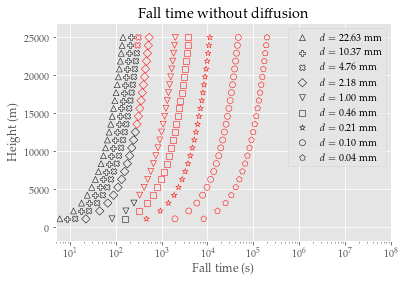

In [12]:
#Bonadonna Fig 2a

markers = ['^', 'P', 'X', 'D', 'v', 's', '*', 'o', 'p']

fig = plt.figure()
ax = plt.gca()

for i, v in enumerate(vtl):
    fall_time = heights/v
    colors = np.array(['k']*len(fall_time))
    colors[fall_time > FALL_TIME_THRESHOLD] = 'r'
    ax.scatter(fall_time, heights, 
               marker = markers[i], facecolor="None", edgecolor=colors, 
               label=r"$d=%.2f$ mm"%(partDiams[i]*1000.))
ax.set_xlim(left=5, right=1e8)
plt.title("Fall time without diffusion")
plt.xscale('log')
plt.legend()
plt.xlabel("Fall time (s)")
plt.ylabel("Height (m)")
plt.show()

#### Figure 2b
Figure 2b shows the horizontal diffusion time as a function of release altitude, as calculated with an eddy diffusivity value of of $K=0.5$.

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


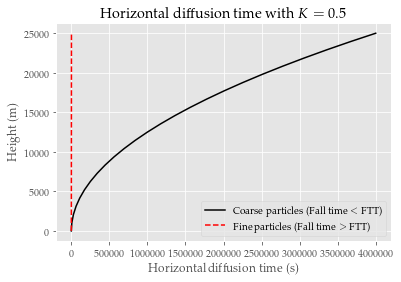

In [13]:
fig = plt.figure()
ax = plt.gca()
ax.plot(diffusionTimeLinear(heights, 0.5), heights, 'k-', label="Coarse particles (Fall time $<$ FTT)")
ax.plot(diffusionTimePower(heights), heights, 'r--', label="Fine particles (Fall time $>$ FTT)")

plt.title("Horizontal diffusion time with $K=0.5$")
plt.legend()
plt.xlabel("Horizontal diffusion time (s)")
plt.ylabel("Height (m)")
plt.show()



It is clear that this is not physically realistic. This plot implies that coarse particles are subject to much more diffusion than the fines. The fines don't seem to diffuse at all. 

We therefore redrew this plot with $K=1000$, showing much more physical results that match the published material. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


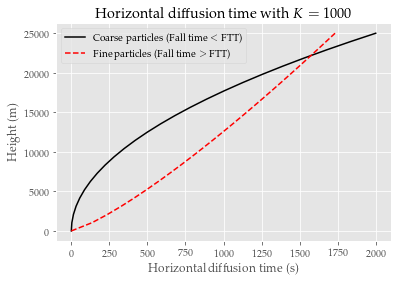

In [14]:
#Bonadonna Fig 2b, K=1000
fig = plt.figure()
ax = plt.gca()
ax.plot(diffusionTimeLinear(heights, 1000.), heights, 'k-', label="Coarse particles (Fall time $<$ FTT)")
ax.plot(diffusionTimePower(heights), heights, 'r--', label="Fine particles (Fall time $>$ FTT)")

plt.title("Horizontal diffusion time with $K=1000$")
plt.legend()
plt.xlabel("Horizontal diffusion time (s)")
plt.ylabel("Height (m)")
plt.show()

#### Figure 2c

Going forth with $K=1000$, we attempt to recreate Figure 2c. This shows the total fall time, which is a combination of the fall time and the horizontal diffusion time. Here a clear discontinuity is shown at the fall time threshold, as expected. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


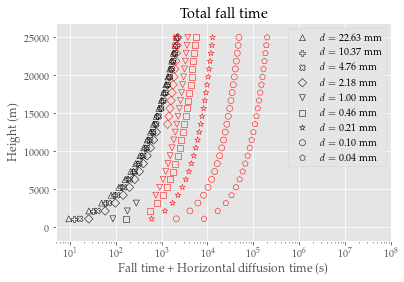

In [15]:
K = 1000.
fig = plt.figure()
ax = plt.gca()

for i, v in enumerate(vtl):
    fall_time = heights/v
    total_fall_time = fall_time.copy()
    colors = np.array(['k']*len(fall_time))
    for j, ft in enumerate(fall_time):
        if ft < FALL_TIME_THRESHOLD:
            total_fall_time[j] = timeLinear(heights[j], v, K)
        else: 
            colors[j] = 'r'
            total_fall_time[j] = timePower(heights[j], v)
    ax.scatter(total_fall_time, heights, 
               marker = markers[i], facecolor="None", edgecolor=colors, 
               label=r"$d=%.2f$ mm"%(partDiams[i]*1000))
ax.set_xlim(left=5, right=1e8)
plt.title("Total fall time")
plt.xscale('log')
plt.legend()
plt.xlabel("Fall time + Horizontal diffusion time (s)")
plt.ylabel("Height (m)")
plt.show()

#### Figure 2d

Finally, we recreate Figure 2d, showing the values of the diffusion coefficient that is to be used in the diffusion Gaussian equation. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


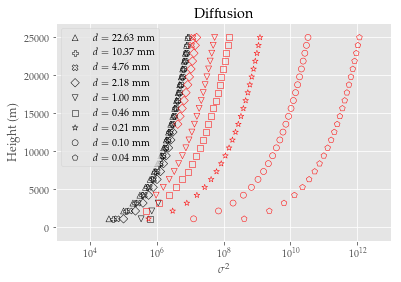

In [16]:
#Bonadonna Fig 2d
K = 1000.
fig = plt.figure()
ax = plt.gca()

for i, v in enumerate(vtl):
    fall_time = heights/v
    sigma_sqr = fall_time.copy()
    colors = np.array(['k']*len(fall_time))
    for j, ft in enumerate(fall_time):
        if ft < FALL_TIME_THRESHOLD:
            sigma_sqr[j] = linearDiffusion(heights[j], v, K)
        else: 
            colors[j] = 'r'
            sigma_sqr[j] = powerDiffusion(heights[j], v)
    ax.scatter(sigma_sqr, heights, 
               marker = markers[i], facecolor="None", edgecolor=colors, 
               label=r"$d=%.2f$ mm"%(partDiams[i]*1000))
ax.set_xlim(left=1e3, right=1e13)
plt.title("Diffusion")
plt.xscale('log')
plt.legend()
plt.xlabel("$\sigma^2$")
plt.ylabel("Height (m)")
plt.show()

## Diffusion Gaussian

We would now like to investigate the function that governs the dispersal of the particles. 

$f_{i,j}(x,y) = \frac{1}{2\pi\sigma_{i,j}}
\exp \left( - \frac{(x - \bar{x}_{i,j})^2 + (y - \bar{y}_{i,j})^2}{2\sigma_{i,j}^2}\right) \quad$ (Eq B5)


This equation takes in the appropriate diffusion equation as its variance. We will use a 1D approximation with no wind. 

For simplicity, we will only look at the particles that fall out from the very top of the plume, as these particles should disperse the furthest, and represent the "worst case". 


Below is the vertical fall times (without diffusion) for each of the grain size classes, given that they are falling out from 25 km.

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


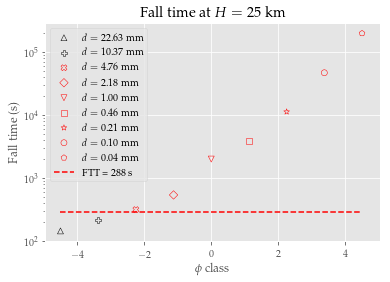

In [17]:
#Calc Fall time
fallTime = PLUME_HEIGHT/vtl
fig = plt.figure()
ax = plt.gca()
for i, phi in enumerate(classes):
    color='k'
    if fallTime[i] > FALL_TIME_THRESHOLD:
        color='r'
    ax.scatter(phi, fallTime[i], marker=markers[i], facecolor="None", edgecolor=color, 
               label=r"$d=%.2f$ mm"%(partDiams[i]*1000))
    
ax.hlines(FALL_TIME_THRESHOLD, min(classes), max(classes), colors='r', linestyles='dashed', 
          label="FTT = %d s"%FALL_TIME_THRESHOLD)
plt.title("Fall time at $H = %d$ km"%int(PLUME_HEIGHT/1000.))
plt.yscale('log')
plt.legend()
plt.xlabel("$\phi$ class")
plt.ylabel("Fall time (s)")
plt.show()


We can now recreate Eq B5 for our 1D case, as well as a 2D version for later. 

In [18]:
def calcFr(diffusion, distance):
    fr =  1./(2. * np.pi * diffusion)
    top = -(2. * (distance * distance)) / (2. * diffusion)
    return fr * np.exp(top)

def calcFr2D(diffusion, distance):
    fr =  1./(2. * np.pi * diffusion)
    top = -((x * x) + (y * y)) / (2. * diffusion)
    return fr * np.exp(top)

We mey now investigate the effect of the two most influential input constants on our dispersal: $K$ and FTT. 

In our previous investigation, a value of 0.5 as used for $K$, and a FTT of 288 s was used. 

The results of this are shown below, separated by grain size. Once again, particles that are subject to linear diffusion are shown in black, and power law diffusion in red. Black is coarse, red is fine. 

Linear and log plots are shown side by side to show the decay of the functions in great detail. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\ticker.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


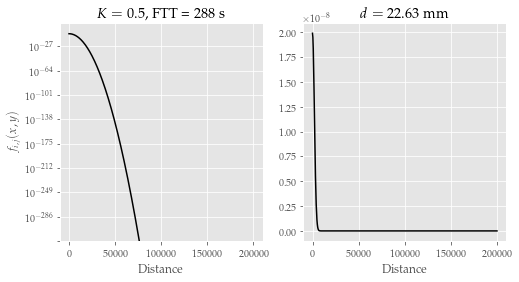

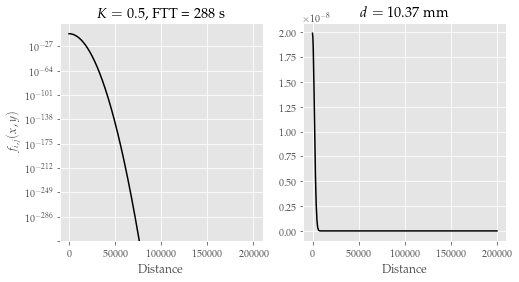

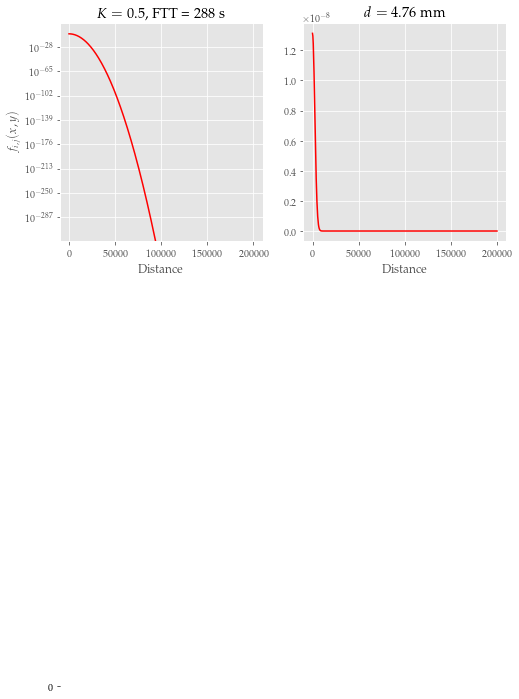

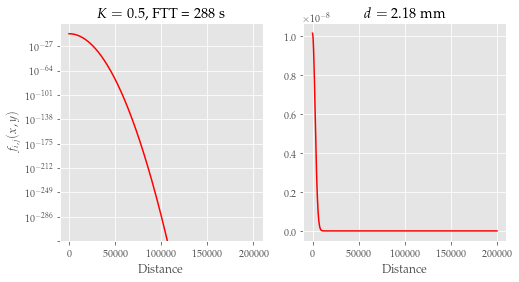

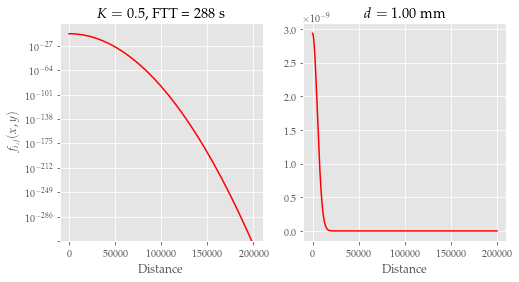

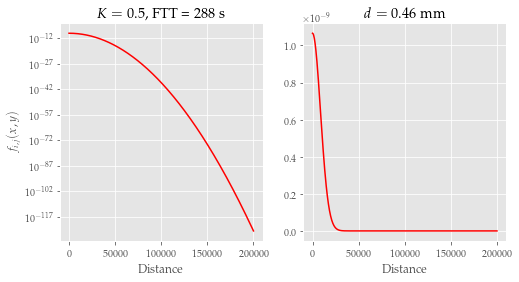

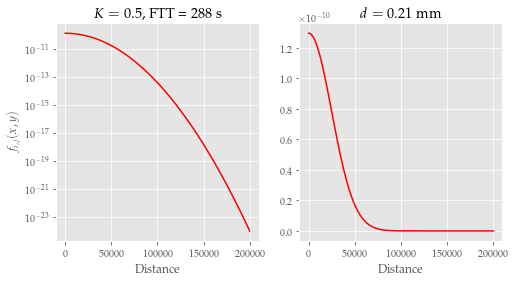

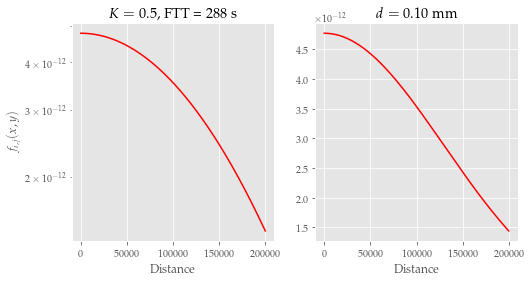

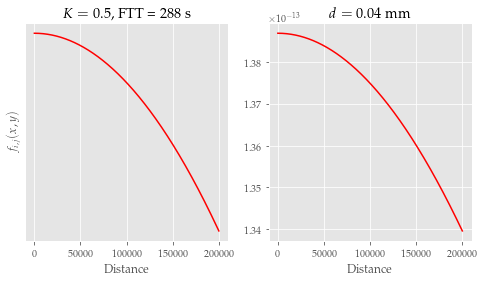

In [19]:
K = 0.5
FTT = 288
for i, phi in enumerate(classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(
        8, 4), facecolor='w', edgecolor='k')
    if fallTime[i] < FTT:
        color='k'
        diffusion = linearDiffusion(PLUME_HEIGHT, vtl[i], K)
    else:
        diffusion = powerDiffusion(PLUME_HEIGHT, vtl[i])
        color='r'
    f = calcFr(diffusion, distances)
    ax1.semilogy(distances, f, c=color)
    ax2.plot(distances, f, c=color)
#     plt.yscale('log')
    ax2.set_title(r"$d=%.2f$ mm"%(partDiams[i]*1000))
    ax1.set_title(r"$K = %.1f$, FTT = %d s"%(K, FTT))
    ax1.set_xlabel("Distance")
    ax2.set_xlabel("Distance")
    ax1.set_ylabel("$f_{i,j}(x,y)$")
#     plt.tight_layout()
    plt.show()

Here we can see that coarser grain sizes are deposited close to the vent, and fines are diffused further, as expected. 

Next, we will look at a diffusion constant of $K=1000$, which we determined to give more physical diffusion. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


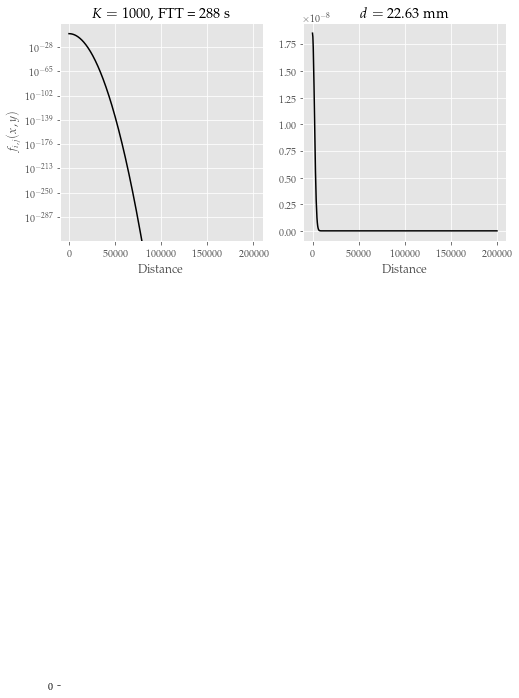

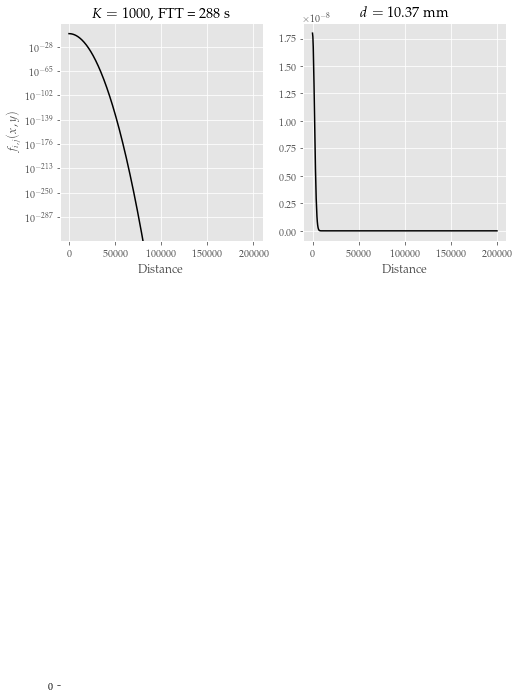

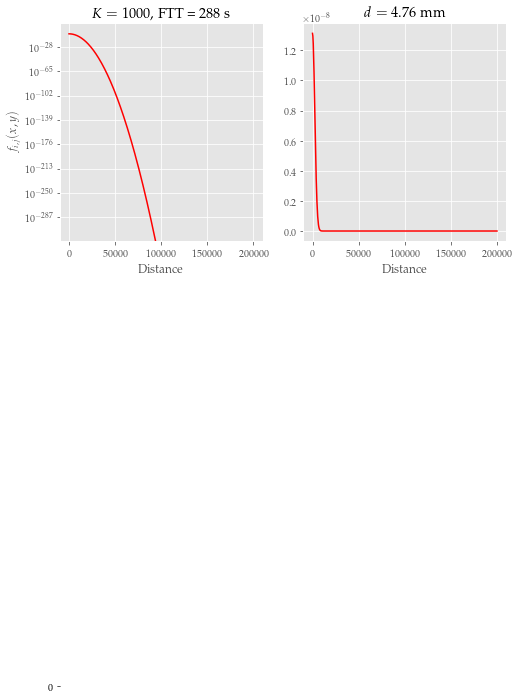

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\ticker.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


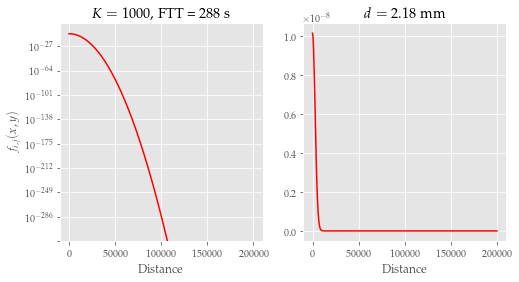

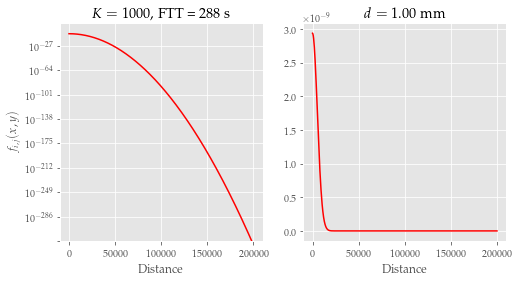

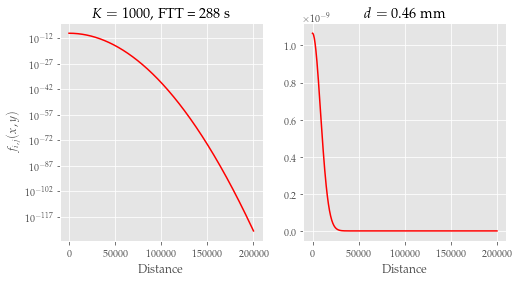

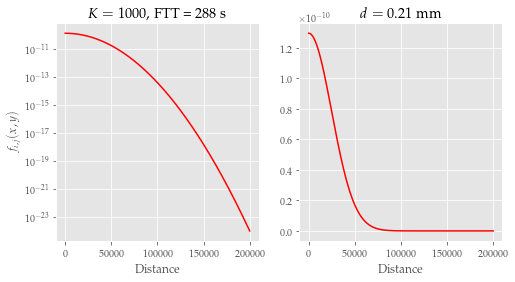

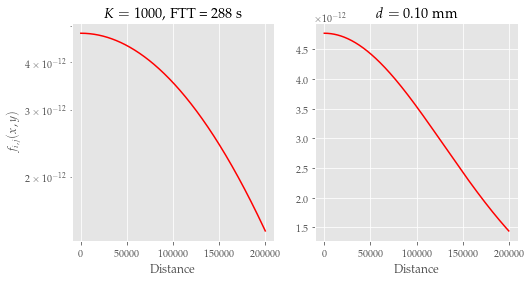

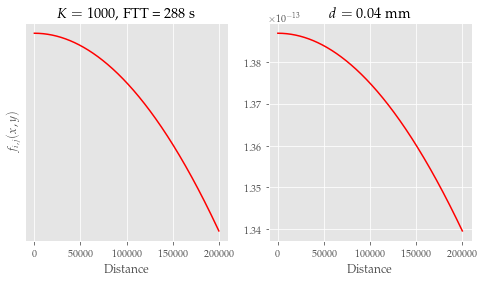

In [20]:
K = 1000
FTT = 288
for i, phi in enumerate(classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(
        8, 4), facecolor='w', edgecolor='k')
    if fallTime[i] < FTT:
        color='k'
        diffusion = linearDiffusion(PLUME_HEIGHT, vtl[i], K)
    else:
        diffusion = powerDiffusion(PLUME_HEIGHT, vtl[i])
        color='r'
    f = calcFr(diffusion, distances)
    ax1.semilogy(distances, f, c=color)
    ax2.plot(distances, f, c=color)
#     plt.yscale('log')
    ax2.set_title(r"$d=%.2f$ mm"%(partDiams[i]*1000))
    ax1.set_title(r"$K = %d$, FTT = %d s"%(K, FTT))
    ax1.set_xlabel("Distance")
    ax2.set_xlabel("Distance")
    ax1.set_ylabel("$f_{i,j}(x,y)$")
#     plt.tight_layout()
    plt.show()

The results appear to be near identical, indicating that $K$ does not appear to matter at low values of FTT. 

We now try a larger value of FTT, with $K$ remaining at 1000. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


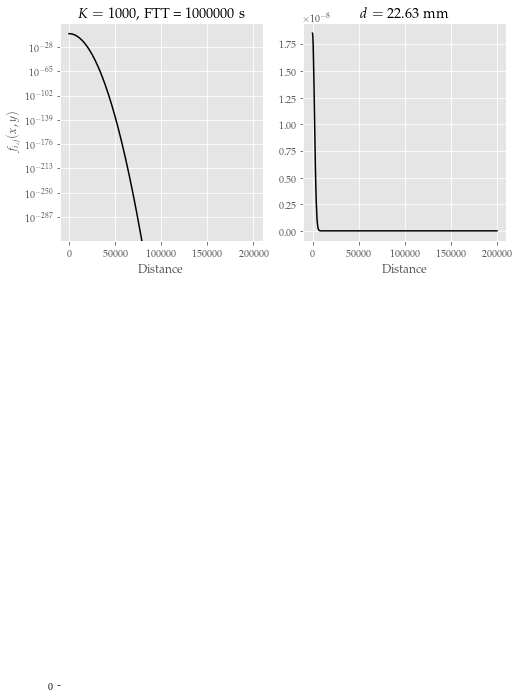

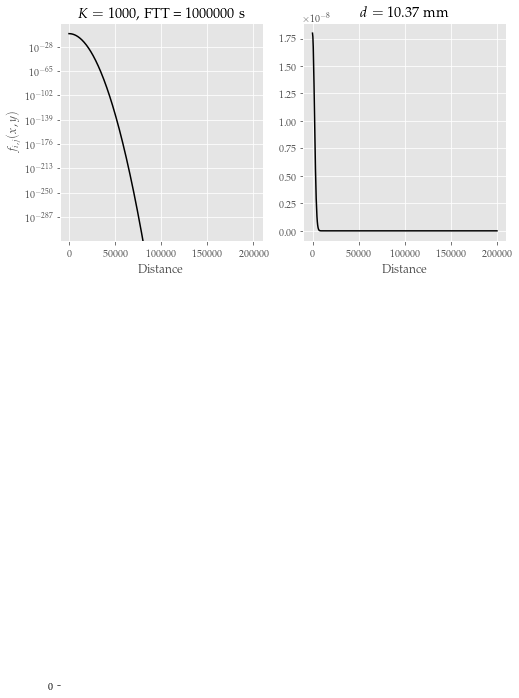

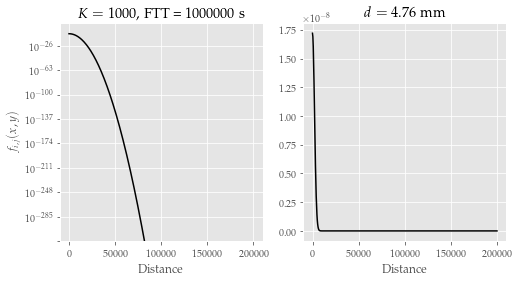

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\ticker.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


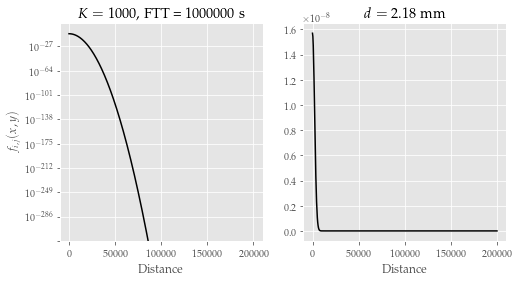

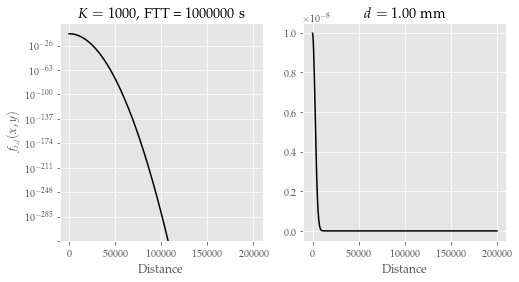

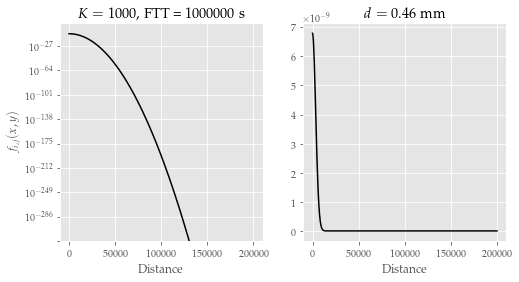

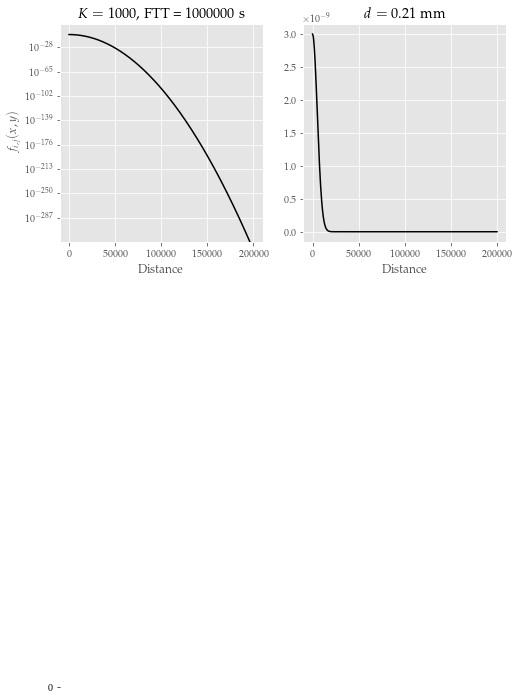

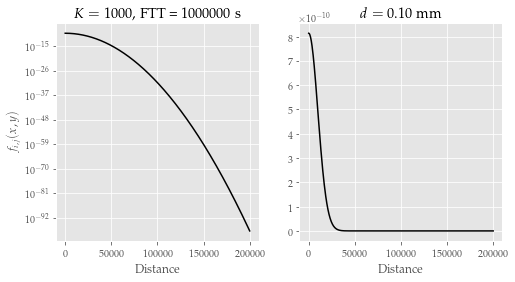

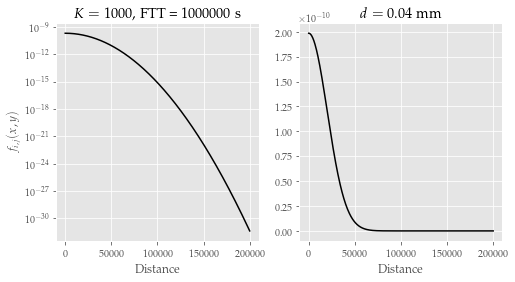

In [21]:
K = 1000
FTT = 1e6
for i, phi in enumerate(classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(
        8, 4), facecolor='w', edgecolor='k')
    if fallTime[i] < FTT:
        color='k'
        diffusion = linearDiffusion(PLUME_HEIGHT, vtl[i], K)
    else:
        diffusion = powerDiffusion(PLUME_HEIGHT, vtl[i])
        color='r'
    f = calcFr(diffusion, distances)
    ax1.semilogy(distances, f, c=color)
    ax2.plot(distances, f, c=color)
#     plt.yscale('log')
    ax2.set_title(r"$d=%.2f$ mm"%(partDiams[i]*1000))
    ax1.set_title(r"$K = %d$, FTT = %d s"%(K, FTT))
    ax1.set_xlabel("Distance")
    ax2.set_xlabel("Distance")
    ax1.set_ylabel("$f_{i,j}(x,y)$")
#     plt.tight_layout()
    plt.show()

It now becomes clear that all particles are treated as course particles, and diffused linearly. The results appear to be a more substantial deposit for the fines, that is more concentrated at the vent. There is not as clear a distiction between coarse and fine grains, as they are all dispersed in similar "concentrations" (keeping in mind that this Gaussian does not directly relate to mass or concentration, but rather theoretical dispersal). 

Finally, we use our smaller (and likely incorrect) value of $K$, along with a very large FTT. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\ticker.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


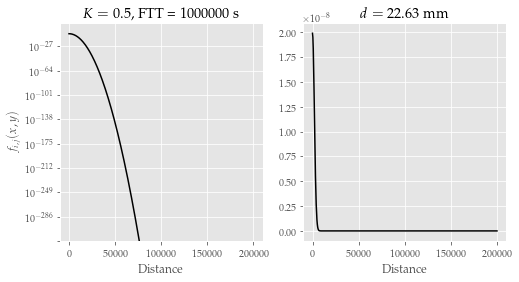

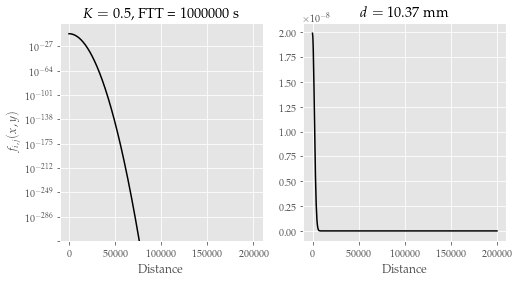

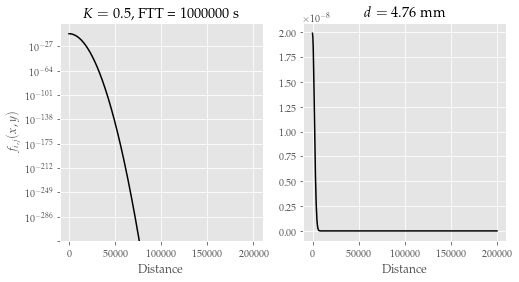

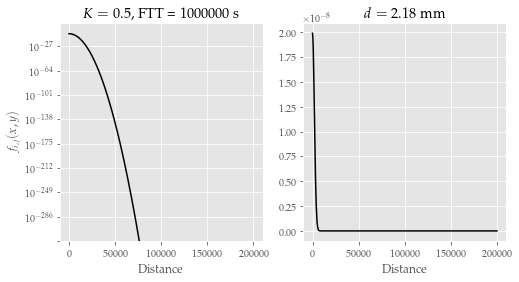

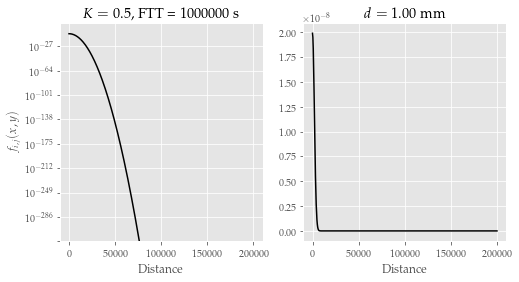

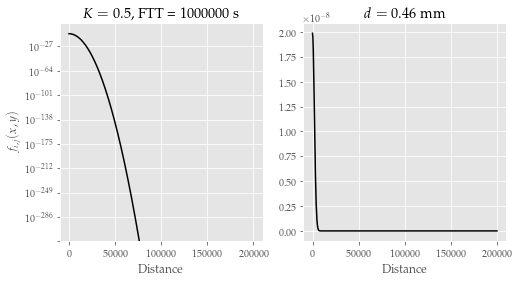

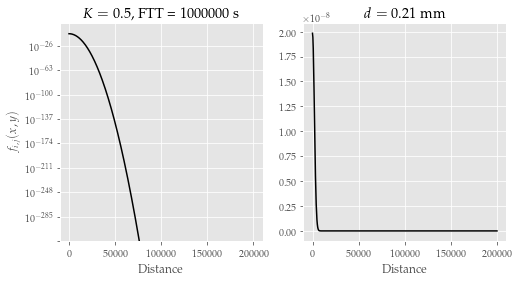

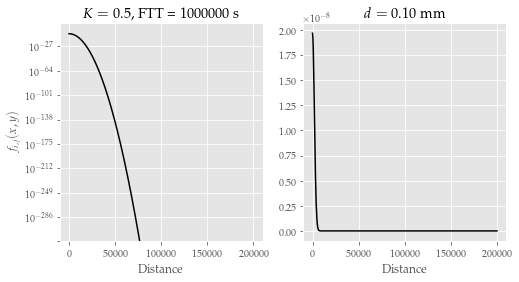

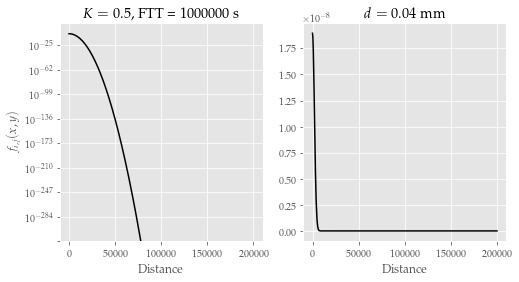

In [22]:
K = 0.5
FTT = 1e6
for i, phi in enumerate(classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(
        8, 4), facecolor='w', edgecolor='k')
    if fallTime[i] < FTT:
        color='k'
        diffusion = linearDiffusion(PLUME_HEIGHT, vtl[i], K)
    else:
        diffusion = powerDiffusion(PLUME_HEIGHT, vtl[i])
        color='r'
    f = calcFr(diffusion, distances)
    ax1.semilogy(distances, f, c=color)
    ax2.plot(distances, f, c=color)
#     plt.yscale('log')
    ax2.set_title(r"$d=%.2f$ mm"%(partDiams[i]*1000))
    ax1.set_title(r"$K = %.1f$, FTT = %d s"%(K, FTT))
    ax1.set_xlabel("Distance")
    ax2.set_xlabel("Distance")
    ax1.set_ylabel("$f_{i,j}(x,y)$")
#     plt.tight_layout()
    plt.show()

This shows something interesting. All particles are diffused linearly, but all reach a value of 0 at around 80km from the vent. Grain size does not appear to affect this dispersal at all. 

This phenomenon was observed in the last progress report, where a large value of FTT resulted in zero accumulation beyond a radius of around 80 km. 

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


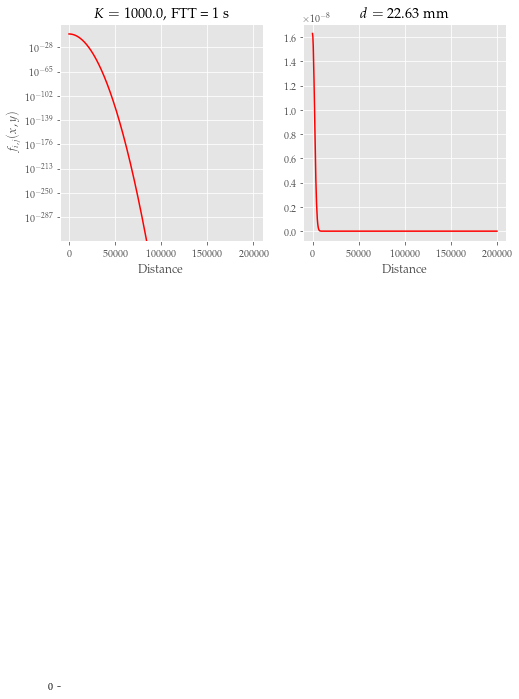

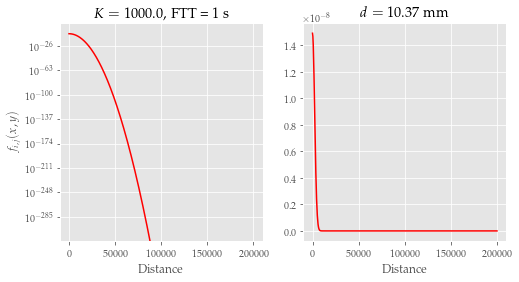

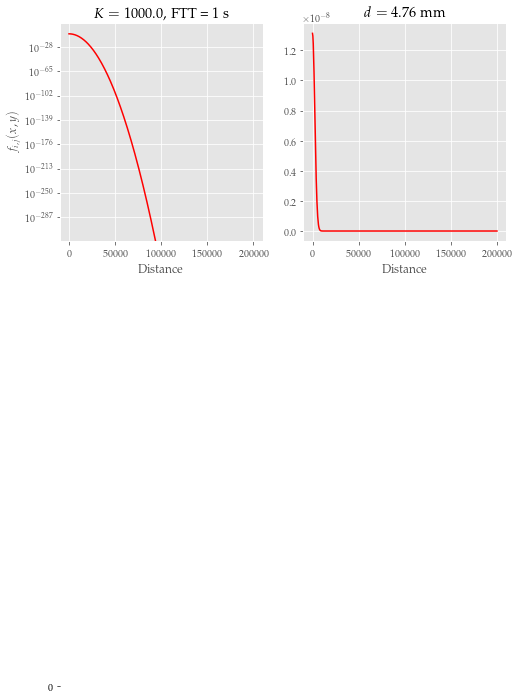

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\ticker.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


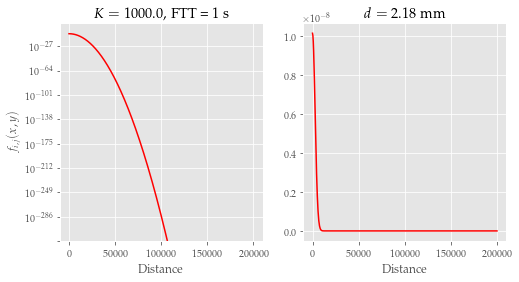

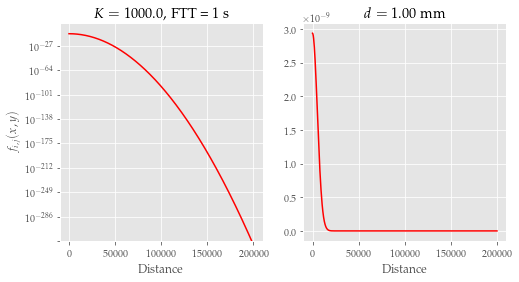

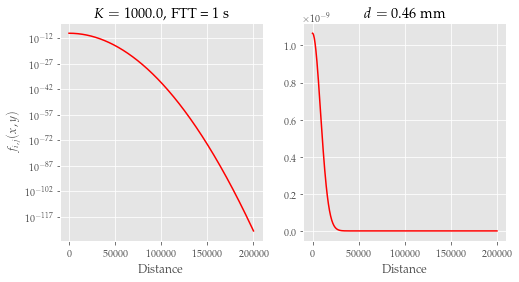

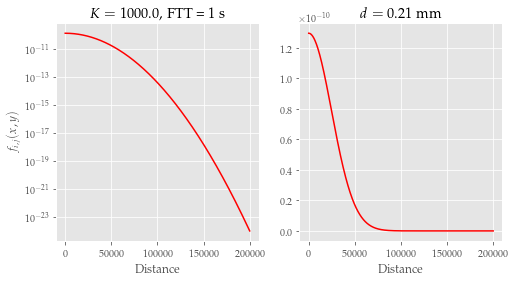

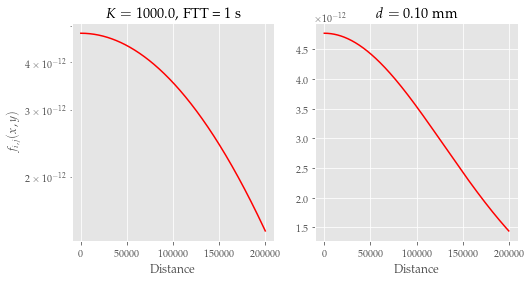

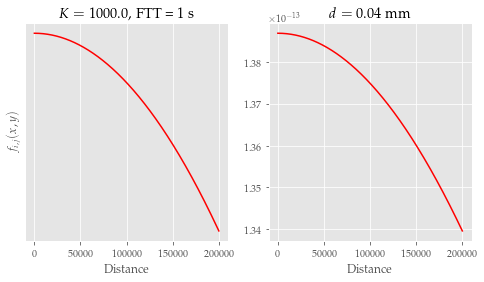

In [25]:
K = 1000
FTT = 1
for i, phi in enumerate(classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(
        8, 4), facecolor='w', edgecolor='k')
    if fallTime[i] < FTT:
        color='k'
        diffusion = linearDiffusion(PLUME_HEIGHT, vtl[i], K)
    else:
        diffusion = powerDiffusion(PLUME_HEIGHT, vtl[i])
        color='r'
    f = calcFr(diffusion, distances)
    ax1.semilogy(distances, f, c=color)
    ax2.plot(distances, f, c=color)
#     plt.yscale('log')
    ax2.set_title(r"$d=%.2f$ mm"%(partDiams[i]*1000))
    ax1.set_title(r"$K = %.1f$, FTT = %d s"%(K, FTT))
    ax1.set_xlabel("Distance")
    ax2.set_xlabel("Distance")
    ax1.set_ylabel("$f_{i,j}(x,y)$")
#     plt.tight_layout()
    plt.show()

In [27]:
np.linspace(1, -1, 5)

array([ 1. ,  0.5,  0. , -0.5, -1. ])